# Streamflow visualization

Streamflow is a spatio-temporal process. Water runs in rivers and is transported downstream in such amount of time. If we want to understand e.g. how floods occur, we need to visualize how precipitation is transformed into runoff in space and time. In this notebook, I will show that this can be achieved by combining a spatial model and a temporal model through a hydrological partition.

## Spatial model

A great dataset for visualizing river networks is [HydroSHEDS](http://hydrosheds.cr.usgs.gov/index.php)'s flow accumulation maps. They have been created using data from the Shuttle Radar Topography Mission (SRTM), which mapped the Earth topography in the form of a DEM (digital elevation model). The following figure showns South America's topography according to SRTM, and the flow accumulation map derived from it.

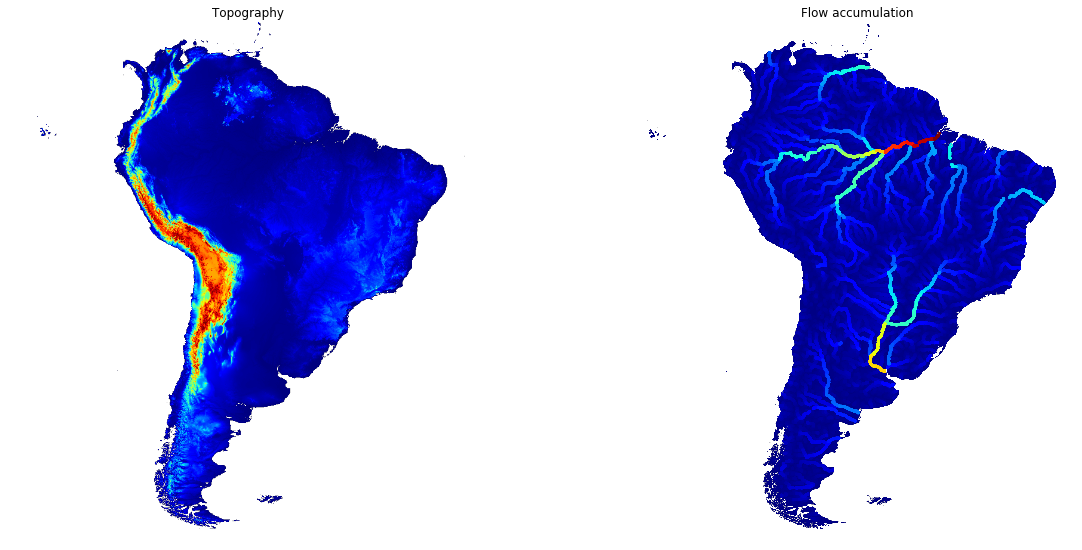

In [1]:
from gross_1 import *
%matplotlib inline

plt.figure(figsize = (20, 20))

plt.subplot(221)
plt.imshow(np.where(dem[::10, ::10] < 0, np.nan, dem[::10, ::10]).clip(0, 5000))
plt.title('Topography')
plt.axis('off')

radius = 10
circle = np.zeros((2 * radius, 2 * radius)).astype('uint8')
cx, cy = radius, radius
y, x = np.ogrid[-radius: radius, -radius: radius]
index = x**2 + y**2 <= radius**2
circle[cy - radius:cy + radius, cx - radius:cx + radius][index] = 1
streamflow = np.sqrt(acc[::3, ::3])
streamflow = scipy.ndimage.maximum_filter(streamflow, footprint = circle)
plt.subplot(222)
plt.imshow(streamflow)
plt.title('Flow accumulation')
plt.axis('off')

plt.show()

In the topograpgy map, the Amazon river is clearly visible through the valleys it has created, but this does not give us any valuable information on the streamflow. For that, the flow accumulation map is much more relevant. It is derived from the DEM through a flow direction map. For each pixel of the DEM, a flow direction is computed by looking at the surrounding pixels and choosing the pixel with a lower altitude. Note that this step is not that easy because the pixel can be in a "hole", which in reality can result in a lake or not. Also, plains are tricky because the DEM resolution may not be sufficient to reveal any slope, so some manual processing may be required. But in the end, each pixel should "flow" to one and only one surrounding pixel. The flow accumulation map is obtained by counting all the pixels that flow to a given pixel, and affecting that count to this pixel. This translates to the upstream area corresponding to each pixel. The result is the flow accumulation map shown above (with some minor tricks to better visualize both small and big rivers).

There is a lot of information in this map. Because it was obtained by mimicking the rainfall-runoff process (by "droping pixels on the map" and letting them flow, a lot like rainfall is transformed into runoff in reality), it gives a good representation of the hydrographic network. But not only are we able to see rivers, we also get an idea of their relative streamflow. For instance, we can see that the Amazon river is the biggest river in South America, solely on the basis of its basin's drained area. This map is a purely spatial model of the streamflow, where precipitation, evapotranspiration, and soil characteristics are uniform, both in space and time. I call it a *potential streamflow* model. Since the uniformity assumption is not true in reality, we need to apply this spatial model to smaller regions, where it can be considered true. These regions must have some characteristics that are linked to the temporal modelling of the streamflow, which should be explained first.

## Temporal model

Since all the spatial information is carried by the spatial model, the temporal model should only focus on the temporal information. This is exactly what lumped rainfall-runoff models do. They simulate the streamflow (in time) at the oulet of a basin based on the mean (in space) precipitation and evapotranspiration over the basin. [Irstea](http://webgr.irstea.fr/?lang=en) developed a series of conceptual lumped hydrological models that are both lightweight and performant. They also have a low number of parameters, which makes them easy to calibrate. For instance, the *GR4H* model (shown below) has only 4 parameters (*X1, X2, X3, X4*) and runs at a hourly time step. It is calibrated by walking through its parameter space and fitting its simulated streamflow (*Q*) to a reference streamflow, given a precipitation (*P*) and a potential evapotranspiration (*PE*) time series.

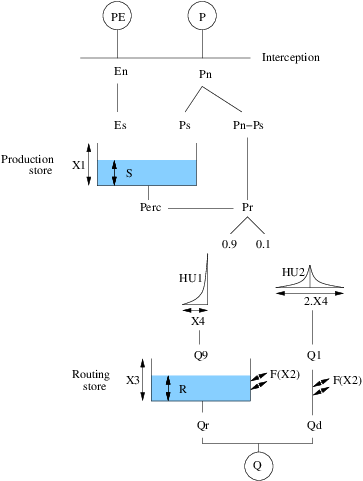

In [2]:
from IPython.display import Image
Image('data/gr4h.png')

A first approximation of spatio-temporal streamflow visualization consists of affecting a (simulated or observed) streamflow value to the oulet of the basin, and letting the spatial model infer the streamflow inside the basin. But this approach fails at taking into account the time it takes for water to flow. For instance, water flowing down the Andes would have an immediate effect on the streamflow at the mouth of the Amazon river, which is clearly not true at a hourly time step. This simple combination of the spatial model and the temporal model lacks a propagation model. But it means that the basin cannot be considered as a whole anymore. It has to be split into smaller pieces, or *subbasins*, such that water flows from one subbasin to the other. This is done through what I call basin partitioning.

## Basin partitioning

The idea is to combine the spatial and the temporal models in the simple way that was described above, but to small enough regions where:
* the streamflow propagation effect can be neglected,
* the spatial variability of precipitation, evapotranspiration, and soil characteristics can be neglected.

These regions must have a similar area, and must hydrologically flow from one to the other, so that the whole basin consists of connecting all the regions together through a propagation model. It turns out that these regions must be subbasins, i.e. nested watersheds. A subbasin produces a streamflow from the rainfall over its area, which flows into the next subbasin whose streamflow feeds the next subbasin, etc. An example of basin partition is shown below for the Amazon river.

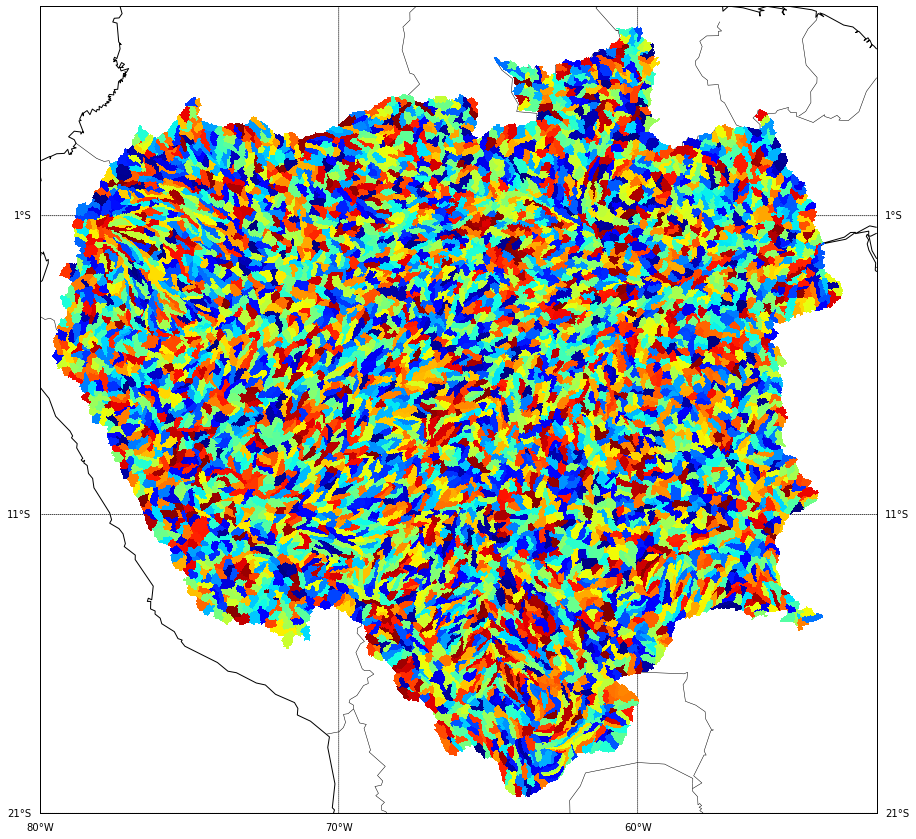

In [3]:
show_ws([[i] for i in df_ws.index], 15)

## Calibration method

One of the big difficulties is to calibrate e.g. the GR4H model for all the subbasins, so that they produce a streamflow at the outlet of the whole basin which matches a reference streamflow. It surely cannot be done simultaneously, but there is a way to do it iteratively. It starts with splitting the whole basin in two nested subbasins of approximately the same area, as shown in the figure below.

In [4]:
odr0, odr1 = split_ws(get_odr_startswith(df_ws.index, '0'))

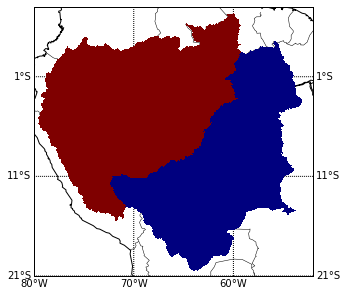

In [5]:
show_ws([odr0, odr1], 5)

The two subbasins are calibrated simultaneously so that the sum of their streamflows results in the reference streamflow. The propagation model used for the upstream subbasin (A) is a simple delay. But the downstream subbasin (B) can also be split into two subbasins, C and D, which can in turn be calibrated simultaneously. This time, the sum of their streamflows and the streamflow of subbasin A must match the reference streamflow. 

In [6]:
odr2, odr3 = split_ws(odr0)

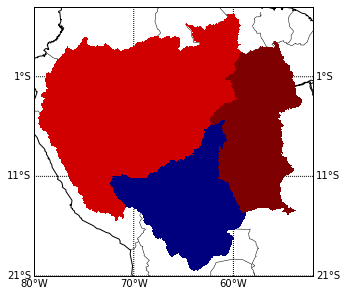

In [7]:
show_ws([odr1, odr2, odr3], 5)

Subbasin A can be split into two subbasins, E and F, which can be calibrated simultaneously. The sum of their streamflows and the streamflows of subbasins C and D must match the reference streamflow.

In [8]:
odr4, odr5 = split_ws(odr1)

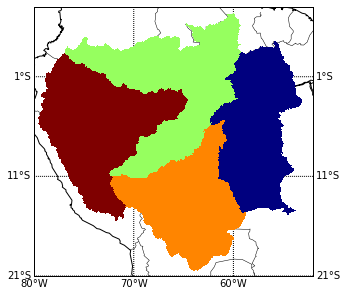

In [9]:
show_ws([odr2, odr3, odr4, odr5], 5)

And so on, until there is no subbasin to split anymore. In the end, this calibration algorithm is quite powerful, because it allows to traceback the streamflow from the outlet of the basin to virtually any point inside the basin. In a way, it is very analogous to remote sensing. And it makes a lot of sense because it is easier to measure the streamflow downstream, near the sea, where people tend to live, rather than e.g. in the middle of the Amazon forest.

## The end result

Once every subbasin has been calibrated, it is just a matter of simulating everything together. In the animation below, the streamflow intensity is indicated by different colors, but that was not enough. In order to have a more dynamic map, and to actually *see* rainfall getting transformed into streamflow, I found it interesting to visualize flood waves through an increase of the river width. The result is quite funny but it also gives an insight on the flood generation processes. One can see that it is often a question of synchronicity in the various flood wave propagations.

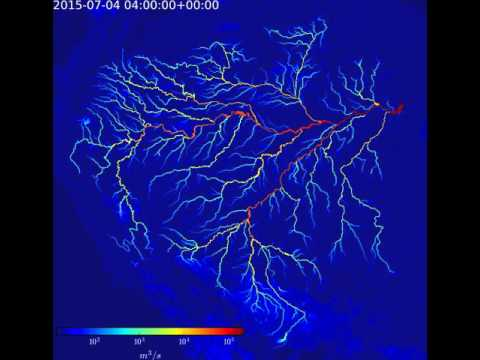

In [10]:
from IPython.display import YouTubeVideo
YouTubeVideo('qCbMgEsFyUQ')